In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,y = mnist['data'], mnist['target']
print('X shape:',X.shape)
print('y shape:',y.shape)

#There are 70,000 images and each image has 784 features. This is because each image is
#28 x 28 pixels and each feature simply represents one pixel's intensity from 0 to 255

X shape: (70000, 784)
y shape: (70000,)


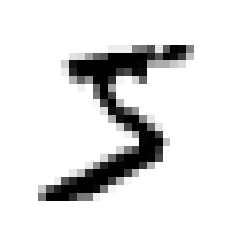

It is the number  5


In [21]:
#Lets take a peek at one digit from the dataset
import matplotlib as mpl
import matplotlib.pyplot as plt

random_number = 0
some_digit = X[random_number]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()
print('It is the number ', y[random_number])

In [22]:
import numpy as np
y = y.astype(np.uint8)

In [23]:
#Split Train-Test Datasets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let's simplify the problem for now and only try to identify one digit- for example, the number 5.

In [24]:
y_train_5 = (y_train == 5) #True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [25]:
from sklearn.linear_model import SGDClassifier

sgd_clf =  SGDClassifier(random_state =42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [26]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf =  clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


Let's use the 'cross_val_score()' function to evaluate our 'SGDClassifier' model, using K-fold cross-validation with three folds. Remember that K-fold-cross-validation means splitting the training set into K folds (in this case, three) then making predictions and evaluating them on each fold using a model trained on the remaining folds

In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [29]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y= None):
        return self
    
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [30]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

## Even all saying none of them has 5 has accuracy more than %90.

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [31]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images: 53892 of them were correctly classified as non-5s(true negative) while the remaining 687 were wrongly classified as non-5s (false positives). While the remaining 3530 were correctly classified as 5s (true positive), 1891 were wrongly classified as non-5s (false negatives)

* 53892 true negative
* 687 false positive
* 1891 false negative
* 3530 true positive

In [33]:
#Pretend we reach perfection
confusion_matrix(y_train_5,y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called 'precision' of the classifier

precision = TP /(TP + FP)

TP is the number of true positives, and FP is the number of false positives.

recall = TP / (TP + FN)

FN is the number of false negatives.

In [35]:
from sklearn.metrics import precision_score, recall_score

print('precision score: ',precision_score(y_train_5,y_train_pred))
print('recall score: ', recall_score(y_train_5,y_train_pred))

precision score:  0.8370879772350012
recall score:  0.6511713705958311


This means when it claims an image represents a 5, it is correct only 83% of the time. Moreover, it only detects 65% of the 5s.

It is often convenient to combine precision and recall into a single metric called the 'F1-Score' in particular if you need a simple way to compare two classifiers. The F1 score is the 'harmonic mean' of precision and recall. Whereas the regular mean treats all values equally, the **harmonic mean gives much more weight to low values.**

As a result, the classifier will only get a high F1 score if both recall and precision are high

In [37]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (**low recall**) but keeps only safe ones (**high precision**) rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier's video selection).

On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately you can't have it both ways: increasing precision reduces recall, and vice versa. This is called the **precision/recall trade-off**

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = 'decision_function')

In [39]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

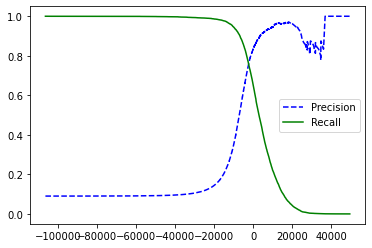

In [45]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label ='Precision')
    plt.plot(thresholds, recalls[:-1],'g-', label = 'Recall')
    plt.legend()

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

You may wonder why the precision curve is bumpier than the recall curve. The reason is that precision may sometimes go down when you raise the threshold. On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.

Another way to select a good precision/recall trade-off is to plot precision directly against recall

### The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to precision versus recall, the ROC curve plots the 'true positive rate (another name for recall)' against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 the true negative rate (TNR) which is the ratio of negative instances that are correctly classified as negative. The TNR is also called 'specificity'. Hence, the ROC curve plots sensitivity (recall) versus specificity.


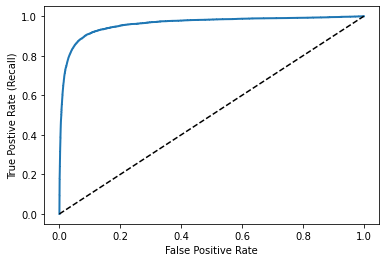

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr,tpr, label = None):
    plt.plot(fpr,tpr, linewidth=2, label = label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Postive Rate (Recall)')

plot_roc_curve(fpr,tpr)
plt.show()

Once again there is a trade-off: The higher the recall (TPR) the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner)